# General data reader for AQUA 
## Units, coordinates, variable name fixer

The reader includes a simple 'data fixer', that has the capability to edit the metadata of the input datasets fixing variable or coordinate names and performing unit conversions.

At the moment this capability is needed to ingest in a uniform way NextGEMS data on Levante.

In [1]:
from aqua import Reader

Let's load some IFS data. We first instantiate a `Reader` object specifying the type of data which we want to read from the catalogue. Then the actual data are read with the `retrieve` method. The `fix=False` for now prevents it from attempting to add unit fixes and other fixes. 

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", fix=False)
data = reader.retrieve()

In [3]:
data

<xarray.Dataset>
Dimensions:  (time: 8329, value: 26306560, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

These are raw IFS data on the original grid. Notice how for example a variable with short name `tp` represents accumulated precipitation. There are 81 variables in this dataset, following ECMWF grib-style short names.

In [4]:
data["tp"]

<xarray.DataArray 'tp' (time: 8329, value: 26306560)>
dask.array<open_dataset-tp, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

Now let's try again dropping the `fix=false` flag with a new Reader definition:

In [5]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d")
data = reader.retrieve()

In [6]:
data

<xarray.Dataset>
Dimensions:    (time: 8329, value: 26306560, level: 5)
Coordinates:
    lat        (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level      (level) int64 1 2 3 4 5
    lon        (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2020-01-20 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d         (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...         ...
    uvb        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z          (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

The resulting data are now adjusted using the instructions in the `config/fixes.yaml` file. 

The fixer has performed a range of services:
1) adopted a common 'coordinate data model': names of coordinates and dimensions (lon, lat etc.), coordinate units and sirection, name (and meaning) of the time dimension. This is implemented by a range of specific json files in the `config/data_models` folder. This is performed using the cf2cdm tool provided by `cfgrib`.
2) derived new variables. In particular from accumulated variables, like "tp" (in m), the equivalent mean-rate variables (like "tprate", paramid 172228; in m/s) have been derived. From "ttr" the equivalent rate "mtntrf" has been derived. The fixer can identify these derived variables just by their shortName (ECMWF and WMO eccodes tables are used).
3) The fixer uses the metpy.units module and is capable of guessing some basic conversions. In particular if a density is missing it will assume that it is the density of water and will take it into account. If there is an extra time unit it will assume that division by the timestep is needed.
4) The specific NextGEMS data on Levante are actually accumulated on a monthly basis (the accumulated value keeps increasing till the last timestep of the month and then it resets). The fixer can perform the needed derivation and convert these back to normal variables accumulated over a single saving step.


In [7]:
data.tprate

<xarray.DataArray 'tprate' (time: 8329, value: 26306560)>
dask.array<mul, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/22)
    paramId:                    260048
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    long_name:                  Total precipitation rate
    factor:                     0.2777777777777778
    offset:                     0
    decumulated:                1
    src_units:                  m
    units_fixed:                1

By default the fixer converts all variables it can directly, so that now `tprate` has been converted also in terms of units to m/s. This behaviour can be switched off by specifying `apply_unit_fix=False`.  

In [8]:
data = reader.retrieve(apply_unit_fix=False)

### ICON example

We open ICON data, this time asking to be a bit more 'verbose' using the `loglevel` flag.

In [9]:
from aqua import Reader, catalogue
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", fix=True, loglevel='INFO')
data = reader.retrieve()

2023-07-19 15:36:04 :: Reader :: INFO     -> Updating the log_level to INFO
2023-07-19 15:36:04 :: Streaming :: INFO     -> Updating the log_level to INFO
2023-07-19 15:36:04 :: Streaming :: INFO     -> Updating the log_level to INFO
2023-07-19 15:36:06 :: Reader :: INFO     -> iews: N m-2 --> N m**-2
2023-07-19 15:36:06 :: Reader :: INFO     -> inss: N m-2 --> N m**-2
2023-07-19 15:36:06 :: Reader :: INFO     -> skt: K --> K
2023-07-19 15:36:06 :: Reader :: INFO     -> sp: Pa --> Pa
2023-07-19 15:36:06 :: Reader :: INFO     -> msl: Pa --> Pa
2023-07-19 15:36:06 :: Reader :: INFO     -> 10si: m s-1 --> m s**-1
2023-07-19 15:36:06 :: Reader :: INFO     -> ci: 1 --> 1
2023-07-19 15:36:06 :: Reader :: INFO     -> sithick: m --> m
2023-07-19 15:36:06 :: Reader :: INFO     -> 2t: K --> K
2023-07-19 15:36:06 :: Reader :: INFO     -> 10u: m s-1 --> m s**-1
2023-07-19 15:36:06 :: Reader :: INFO     -> 10v: m s-1 --> m s**-1
2023-07-19 15:36:06 :: Reader :: INFO     -> tciw: kg m-2 --> kg m**-2

In this case there was more work to do: all ICON outputs in NextGEMS are more 'cmor-like' in variable names. We have renamed or derived variables to their grib2 equivalents, with correct units (e.g. pr  [kg m-2 s-1] --> tprate [m s**-1]), psl --> msl etc.

In [10]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/33)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tciw      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tclw      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mslhfl    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msshfl    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    10u       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    10v       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msntrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mtntrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msnsrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mtnsrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-07-19 15:36:06 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

### MSWEP example

In [16]:
from aqua import Reader
reader = Reader(model="MSWEP", exp="past", source="monthly")

In [17]:
data = reader.retrieve()

The 'precipitation' variable has now been converted to a standard ECMWF 'tprate' variable, in the correct units.

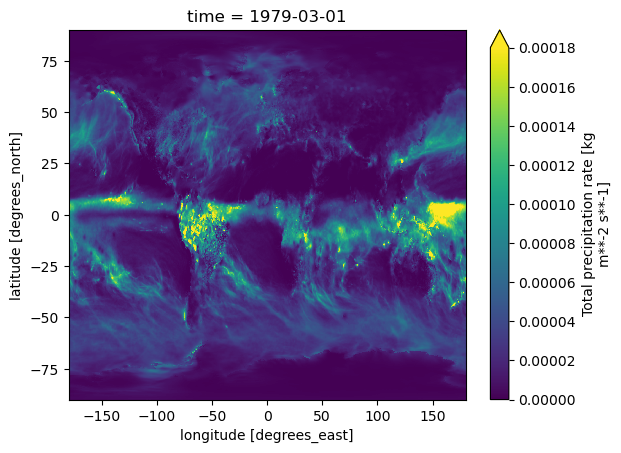

In [21]:
data.tprate.isel(time=1).plot(vmin=0, vmax=1.8e-4)

## Coordinate Data Model conversion

The fixer also converts the input 'coordinate data model' to a common standard data model. Currently by default the (CDS datamodel)[https://confluence.ecmwf.int/display/COPSRV/CDM%3A+Common+data+model+specification+-+v1.0#CDM:Commondatamodelspecificationv1.0-5.1Standardnames] is adopted in `fixes.yaml` as a destination, but other DMs can be specified creating specific json files in the `config/data_models` directory. For each dataset an 'input' datamodel can be specified or switched off (selecing `datamodel: False`)

For example, adopting the CDS datamodel makes sure that dimensions are named lon, lat, time and that they are increasing, among other things.

## Derived variables

In the 'fixer.yaml' file it is possible to specify in a flexible way renamed or derived variables. In particular one can specify that destination shortnames are grib:  then all destination attributes are recovered automatically from eccodes tables (using ecmf conventions). 
Here are some examples of what is possible (see the file for others):

- Just derive a grib variable from a source variable. Unit conversion is automatic. Example for ICON:
```
    tprate:
          source: pr
          grib: true
```

- Define your own derived variable. Example for ERA5:
```
      tprate:
             derived: cp+lsp
             grib: true
```

- Define your own new destination variable (ICON):
```
        mypr:
                derived: pr*86400
                 attributes:
                            units: "mm day-1"
                            long_name: My own test precipitation in mm / day
```

- Just rename and add your own attribute:
```
         msshfl:
               source: hfss
               attributes:
                    long_name: Mean surface sensible heat flux
```
Units are converted automatically as far as possible. 
Writing:
```
      tprate:
             source: tp
             grib: true
```

will effectively convert from tp (in m) to tprate (in m/s) dividing by the accumulation timestep

As an example, let's try and load CERES-SYN daily radiation data. Since these data are not energy balanced, using the fixes.yaml file we can derive energy balanced fluxes and then derive standard ECMWF grib codes (mtntrf and mtnsrf): 

In [14]:
from aqua import Reader
reader = Reader(model="CERES", exp="syn-toa41", source="daily")
data = reader.retrieve()

In [15]:
data

<xarray.Dataset>
Dimensions:                 (time: 7670, lon: 360, lat: 180)
Coordinates:
  * time                    (time) datetime64[ns] 2001-01-01T12:00:00 ... 202...
  * lon                     (lon) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * lat                     (lat) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables:
    toa_sw_all_daily        (time, lat, lon) float32 dask.array<chunksize=(2443, 180, 360), meta=np.ndarray>
    toa_lw_all_daily        (time, lat, lon) float32 dask.array<chunksize=(2443, 180, 360), meta=np.ndarray>
    toa_net_all_daily       (time, lat, lon) float32 dask.array<chunksize=(2443, 180, 360), meta=np.ndarray>
    toa_lw_all_daily_eb     (time, lat, lon) float32 dask.array<chunksize=(2443, 180, 360), meta=np.ndarray>
    toa_sw_all_daily_eb     (time, lat, lon) float32 dask.array<chunksize=(2443, 180, 360), meta=np.ndarray>
    toa_solar_all_daily_eb  (time, lat, lon) float32 dask.array<chunksize=(2443, 180, 360), meta=np.ndarray>
    mtntrf                  (time, lat, lon) float32 dask.array<chunksize=(2443, 180, 360), meta=np.ndarray>
    mtnsrf                  (time, lat, lon) float32 dask.array<chunksize=(2443, 180, 360), meta=np.ndarray>
Attributes:
    title:        CERES SYN1deg Daily data
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:       
    Version:      Edition 4.1: Release Date August 22, 2019
    DOI:          10.5067/Terra+Aqua/CERES/SYN1degDay_L3.004A
    Fill_Value:   Fill Value is -999.0
    history:      2023-07-19 15:36:44 retrieved by AQUA retriever;\n2023-07-1...